# PandaBase Lounge

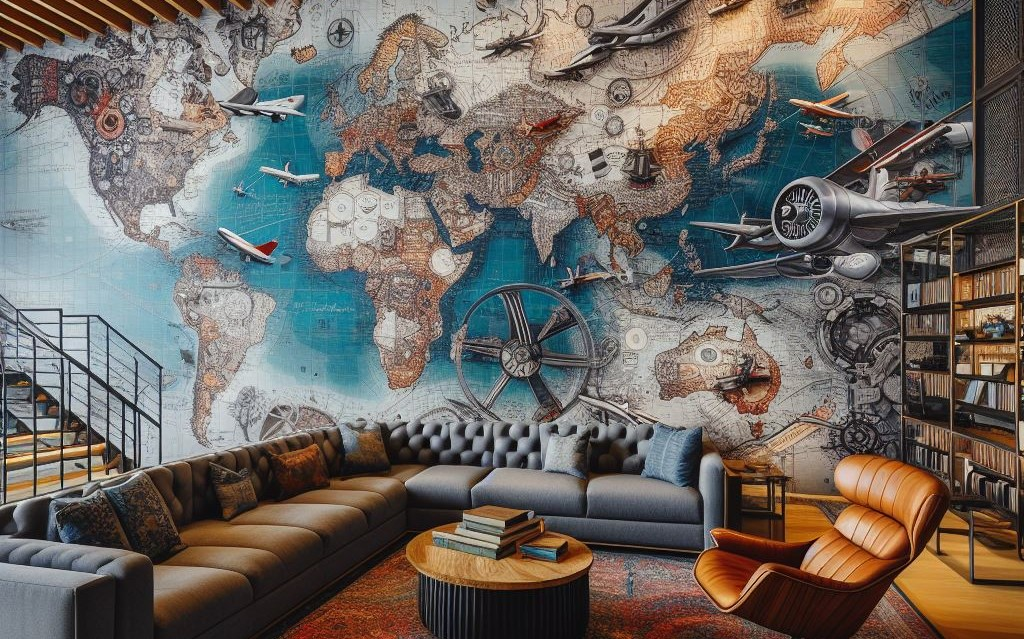

### In this fictional scenario, an airport lounge aims to efficiently track aircraft locations for real-time flight updates on their map displays. The focus is on seamless database maintenance to enable the software team to enhance and update flight information, ensuring an improved user experience.

## 1. Build the PandaBase Class

In [102]:
import sqlite3
import pandas as pd
import random
import numpy as np

The `PandaBase` class contains many methods usefule for maintaining and querying a database. When instantiating this class you give it a database filename with/without a path and if it does not exist it will create the database file for you. You can:
1. create an n-row table of aircraft data
2. run a SQL query
3. view the table head (first 5 rows)
4. delete a table from the database
5. show all available tables
6. show a table's schema
7. insert a row of data into a table
8. Check if a table exists
8. Open and Close a database connection

In [195]:
class PandaBase:
    def __init__(self, database):
        self.database = database
        self.connection = sqlite3.connect(self.database)
        self.cursor = self.connection.cursor()
        
    def create_random_table(self, n_rows, table_name):
        # Check if the table already exists
        if self.table_exists(table_name):
            print(f"Already a table named {table_name}")           
        else:
            # Create the random table
            self.cursor.execute(f"""CREATE TABLE IF NOT EXISTS {table_name} (
                                    id INTEGER PRIMARY KEY,
                                    aircraft_id TEXT NOT NULL,
                                    latitude REAL NOT NULL,
                                    longitude REAL NOT NULL,
                                    altitude REAL NOT NULL,
                                    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP)""")
            # Generate and insert n - random entries
            random_data = []
            for _ in range(n_rows):
                aircraft_id = f"AC{random.randint(1, 999)}"
                latitude = round(random.uniform(-90, 90), 4)
                longitude = round(random.uniform(-180, 180), 4)
                altitude = random.randint(0, 40000)
                # Append data to the DataFrame
                random_data.append((aircraft_id, latitude, longitude, altitude))
            # Insert data from the DataFrame into the database
            self.cursor.executemany(f"""INSERT INTO {table_name}
                                        (aircraft_id, latitude, longitude, altitude)
                                        VALUES (?, ?, ?, ?)""", random_data)
            self.connection.commit()
        
    def query(self, text_query):
        # example: "DELETE FROM your_table WHERE id = 6"
        self.cursor.execute(text_query)
        results = self.cursor.fetchall()
        self.connection.commit()
        # Convert the results to a Pandas DataFrame
        try:
            df = pd.DataFrame(results, columns=[col[0] for col in self.cursor.description])
            #print(df.to_string(index=False))
        except:
            pass
        self.connection.commit()
        return df
        
        
    def table_head(self, table_name):
        self.cursor.execute(f"SELECT * FROM {table_name} LIMIT 5")
        results = self.cursor.fetchall()
        self.connection.commit()
        # Convert the results to a Pandas DataFrame
        try:
            df = pd.DataFrame(results, columns=[col[0] for col in self.cursor.description])
            print(df.to_string(index=False))
        except:
            pass
        self.connection.commit()

    def drop_table(self, table_name):
        #Execute the SQL command to drop the table
        self.cursor.execute(f"DROP TABLE IF EXISTS {table_name}")
        self.connection.commit()
        
    def show_tables(self):
        self.cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")       
        # Fetch all the table names
        table_names = self.cursor.fetchall()
        print("""
---------------------
|       TABLES      |
---------------------
              """)
        # Print the table names
        for table_name in table_names:
            print(table_name[0])
        self.connection.commit()
    
    def table_schema(self, table_name):
        # Execute a query to retrieve the table schema
        self.cursor.execute(f"PRAGMA table_info({table_name});") 
        # Fetch and print the schema
        table_schema = self.cursor.fetchall()
        print("""
---------------------
|       SCHEMA      |
---------------------
              """)       
        for column_info in table_schema:
            column_name = column_info[1]
            data_type = column_info[2]
            not_null = "NOT NULL" if column_info[3] == 1 else ""
            print(f"{column_name} {data_type} {not_null}")
        self.connection.commit()
    
    def insert_row(self, table, value_list):
        self.cursor = self.connection.cursor() 
        self.cursor.execute(f"""INSERT INTO {table}
                                (aircraft_id, latitude, longitude, altitude)
                                VALUES (?, ?, ?, ?)""", value_list)
        self.connection.commit()
        
    def table_exists(self, table_name):
        # Check if the table exists
        self.cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
        result = self.cursor.fetchone()
        # Return True if the table exists, False otherwise
        return result is not None
        
    def close_(self):
        self.connection.commit()
        self.connection.close()

    def open_(self):
        self.connection = sqlite3.connect(self.database)
        self.cursor = self.connection.cursor()

## 2. Create Database and Tables

Remember, the class will create a database with the name provided if it doesn't already exist

In [197]:
db = PandaBase("pandabase.db")

Next, create one table with jet data and one table with prop data

In [198]:
db.create_random_table(1000, 'jets')
db.create_random_table(500, 'prop')

Let's check if those tables show up in the database

In [199]:
db.show_tables()


---------------------
|       TABLES      |
---------------------
              
jets
prop


## 3. Query and View Data

What do the first few rows of the `jets` table look like?

In [200]:
db.table_head('jets')

 id aircraft_id  latitude  longitude  altitude           timestamp
  1       AC430   37.8372   128.3513   21332.0 2023-12-29 16:39:21
  2       AC158   32.2464  -101.0974   19636.0 2023-12-29 16:39:21
  3       AC607   38.4384   -95.5898   18562.0 2023-12-29 16:39:21
  4       AC316  -84.0153   168.2104   37113.0 2023-12-29 16:39:21
  5       AC305  -50.6844    -8.6372   35196.0 2023-12-29 16:39:21


What is the `jets` table schema?

In [201]:
db.table_schema('jets')


---------------------
|       SCHEMA      |
---------------------
              
id INTEGER 
aircraft_id TEXT NOT NULL
latitude REAL NOT NULL
longitude REAL NOT NULL
altitude REAL NOT NULL
timestamp DATETIME 


Time to query some data!

In [202]:
db.query("SELECT COUNT(id) FROM jets")

,COUNT(id)
0,1000


There are **1000** entries in the `jets` table. This matches the rows we specified earlier.

Next, **INNER JOIN** the two tables on matching `aircraft_id`

In [203]:
df = db.query("""

SELECT
    j.id,
    j.aircraft_id AS aircraft_id,
    p.aircraft_id AS jet_id,
    j.latitude AS lat,
    j.longitude AS lon
FROM
    jets AS j
INNER JOIN
    prop AS p
ON j.aircraft_id = p.aircraft_id
LIMIT 10;

""")

df

,id,aircraft_id,jet_id,lat,lon
0,1,AC430,AC430,37.8372,128.3513
1,3,AC607,AC607,38.4384,-95.5898
2,3,AC607,AC607,38.4384,-95.5898
3,5,AC305,AC305,-50.6844,-8.6372
4,7,AC953,AC953,-10.1123,169.0530
5,14,AC334,AC334,-30.7356,121.5486
6,14,AC334,AC334,-30.7356,121.5486
7,17,AC129,AC129,20.1666,22.5439
8,17,AC129,AC129,20.1666,22.5439
9,18,AC204,AC204,-19.2924,-96.3996


## 4.  Plot the Query

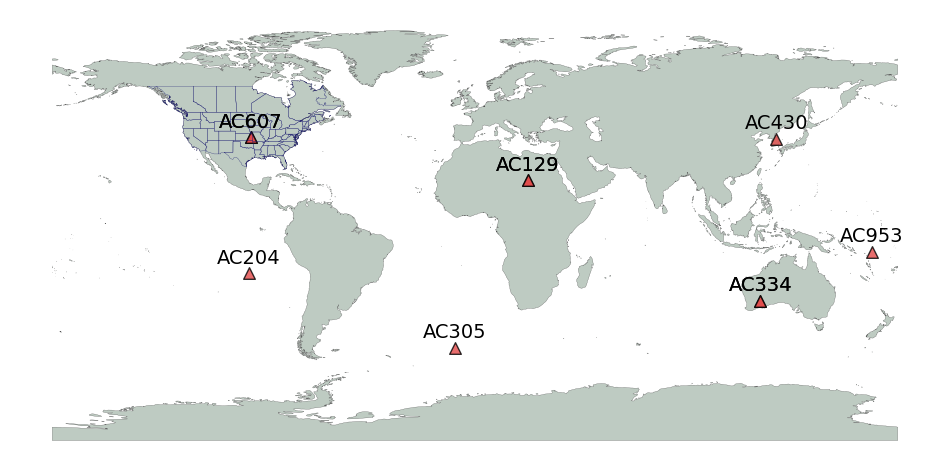

In [204]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create empty lists to store data
names = []
latitudes = []
longitudes = []

# Iterate over rows
for index, row in df.iterrows():
    names.append(row['aircraft_id'])
    latitudes.append(np.round(row['lat'], 2))
    longitudes.append(np.round(row['lon'], 2))

# Create a GeoDataFrame with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(longitudes, latitudes)]

# Create the GeoDataFrame
gdf = gpd.GeoDataFrame({'name': names, 'Latitude': latitudes,
                        'Longitude': longitudes, 'geometry': geometry},
                         crs='EPSG:4326')

# Download the world basemap for context
world = gpd.read_file('ne_50m_land/ne_50m_land.dbf')

# Plot the basemap with the specified extent
fig, ax = plt.subplots(figsize=(12, 10))

world.plot(ax=ax,
           color='#becbc2',
           edgecolor='#505050',
           linewidth=0.2)

#Load state boundaries data
us_states = gpd.read_file(
    'ne_50m_admin_1_states_provinces/ne_50m_admin_1_states_provinces.dbf'
)

us_states = us_states.cx[us_extent[0]:us_extent[1], us_extent[2]:us_extent[3]]

# Plot state boundaries with a different color
us_states.boundary.plot(ax=ax, linewidth=0.2, color='MidnightBlue')

# Plot the GeoDataFrame points on top with customized colors
gdf.plot(ax=ax,
         marker='^',
         color='#E34949',
         edgecolor='black',
         markersize=70,
         alpha=0.8)

# Annotate each point with a name
for x, y, label in zip(gdf.geometry.x,
                       gdf.geometry.y + 4,
                       gdf['name']):
    
    ax.text(x, y, label, fontsize=14, ha='center')

# Remove axis labels
ax.set_axis_off()
plt.show()

## 5. Remove Tables and Close Connection

Once the two tables are removed, the database is empty and the tables will need to be regenereated. Make sure to close the database when you are finished!

In [193]:
db.drop_table('jets')
db.drop_table('prop')

In [194]:
db.show_tables()


---------------------
|       TABLES      |
---------------------
              


There are no more tables in the database

In [58]:
db.close_()